In [4]:
from configparser import ConfigParser, ExtendedInterpolation

import scipy.io
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import seaborn as sns
import pyspike
import os
import joblib

import multiprocessing as mp

from ipywidgets import IntSlider, interact, Dropdown, fixed
from spikelib import spiketools as spkt

import scipy.cluster as cluster
import scipy.spatial.distance as distance
from scipy.spatial.distance import squareform
import sklearn.metrics.cluster as metrics
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

from tqdm import tqdm
from chirp import get_chirp_subevents
import json

%matplotlib inline
config = ConfigParser(interpolation=ExtendedInterpolation())

In [40]:
rootdir = os.getcwd()
with open("params.json") as p:
    params = json.load(p)
    
# Create output folder if it does not exist
if os.path.isdir(params['Output']) == False:
    os.mkdir(params['Output'])

In [41]:
exp_unit = []
spiketimes = []
chirp_psth = []
flash_psth = []

for exp_path in params['Experiments']:
    os.chdir(exp_path)
    cfg_file = 'config.ini'
    config.read(cfg_file)
    
    config.set('PROJECT', 'path', '{}/'.format(os.getcwd()))
    with open(cfg_file, 'w+') as configfile:
        config.write(configfile)
    config.read(cfg_file)

    os.chdir(rootdir)
    exp_path = config['PROJECT']['path']
    exp = config['EXP']['name']
    sorting_file = config['FILES']['sorting']
    sync_file = config['SYNC']['events']
    start_end_path = config['SYNC']['frametime']
    repeated_path = config['SYNC']['repeated']
    sub_events_path = os.path.join(config['SYNC']['folder'],
                               'sub_event_list_{}_chirp.csv'.format(exp))
    output_features = os.path.join(config['SYNC']['folder'],
                                   'chirp_features_{}.csv'.format(exp))

    sorting = config['FILES']['sorting']
    
    names = ['ON', 'OFF', 'adap_0', 'FREQ', 'adap_1', 'AMP', 'adap_2']
    times = [3, 3, 2, 15, 2, 8, 2]
    
    # May be errors while processing due invalid files
    events = get_chirp_subevents(sync_file, start_end_path, repeated_path, sub_events_path, names, times)
    if isinstance(events, pd.DataFrame) is not True:
        print('Error computing chirp sub events')
        continue
    
    sr = 20000.0    
    fields_df = ['start_event', 'end_event']
    
    # Full field chirp
#     events = pd.read_csv(sync_file)
#     chirp_mask = events['protocol_name'] == 'chirp'
#     bound_time = np.array(events[chirp_mask][fields_df]) / sr
    
    # Segmented chirp
#     events = pd.read_csv(sub_events_path, sep=';')

    chirp_mask = events['protocol_name'] == 'chirp'

    mask_on = (events['extra_description'] == 'ON') & chirp_mask
    mask_off = (events['extra_description'] == 'OFF') & chirp_mask
    mask_freq = (events['extra_description'] == 'FREQ') & chirp_mask
    mask_adap = (events['extra_description'] == 'adap_2') & chirp_mask # Using as final chirp times and for amplitude mod
    mask_amp = (events['extra_description'] == 'AMP') & chirp_mask

    on_time = np.array(events[mask_on][fields_df]) / sr
    off_time = np.array(events[mask_off][fields_df]) / sr
    freq_time = np.array(events[mask_freq][fields_df]) / sr
    adap_time = np.array(events[mask_adap][fields_df]) / sr # adap times after amplitude modulation

#     bound_time = np.array(events[chirp_mask][fields_df]) / sr
    bound_time = np.array([freq_time[:, 0], adap_time[:, 1]]).T
    flash_bound = np.array([on_time[:, 0], off_time[:, 1]]).T

#     chirp_dur = np.mean(np.diff(bound_time, axis=1))
    chirp_dur = 27
    
    def format_to_pyspike(trials, stim_dur):
        st = []
        for t in trials:
            st.append(pyspike.SpikeTrain(t, stim_dur))
        return st

    psth_bin = 0.06  # In sec
    fit_resolution = 0.001  # In sec

    chirp_time = np.linspace(0, chirp_dur, int(np.ceil((chirp_dur) / fit_resolution)))
    chirp_bins = np.linspace(0, chirp_dur, int(np.ceil((chirp_dur) / psth_bin)))
    
    flash_dur = 6
    flash_time = np.linspace(0, flash_dur, int(np.ceil((flash_dur) / fit_resolution)))
    flash_bins = np.linspace(0, flash_dur, int(np.ceil((flash_dur) / psth_bin)))
    
    filtered_cells = 0

    with h5py.File(sorting, 'r') as spks:
        idxs = list(spks['spiketimes'].keys())
        uidx = ['Unit_{:04d}'.format(int(i.split('_')[1]) + 1) for i in idxs]
        
        for i, idx in enumerate(idxs):
            trials = spkt.get_trials(np.unique(spks['spiketimes'][idx][:].flatten() / sr), bound_time[:, 0], bound_time[:, 1])
            
            low_spikes = False
            for t in trials:
                if t.shape[0] < 20:
                    low_spikes = True
                    break        
            if low_spikes:
                filtered_cells += 1
                continue

            spikes_chirp = spkt.flatten_trials(trials)

            (psth, _) = np.histogram(spikes_chirp, bins=chirp_bins)
            chirp_resp = spkt.est_pdf(trials, chirp_time, bandwidth=psth_bin, norm_factor=psth.max())
            
            exp_unit.append((exp, uidx[i], idx))
            spiketimes.append(np.asarray(format_to_pyspike(trials, chirp_dur), dtype=object))
            chirp_psth.append(chirp_resp)
            
            # Flash signal for plotting later
            trials = spkt.get_trials(np.unique(spks['spiketimes'][idx][:].flatten() / sr), flash_bound[:, 0], flash_bound[:, 1])
            spikes_flash = spkt.flatten_trials(trials)
            (psth, _) = np.histogram(spikes_flash, bins=flash_bins)
            flash_resp = spkt.est_pdf(trials, flash_time, bandwidth=psth_bin, norm_factor=psth.max())
            flash_psth.append(flash_resp)
    
    print('{} cells below minimum spikes constraint.'.format(filtered_cells))
    print('{} cells valid for {}\n'.format(len(uidx) - filtered_cells, exp))

chirp_psth = np.asarray(chirp_psth)
flash_psth = np.asarray(flash_psth)
print('Total cells for clustering: {}'.format(len(exp_unit)))

165 cells below minimum spikes constraint.
164 cells valid for MR-0227

224 cells below minimum spikes constraint.
66 cells valid for MR-0242

306 cells below minimum spikes constraint.
384 cells valid for MR-0342

Total cells for clustering: 614


In [42]:
num_threads = 4

def flat_unit_pairs(st):
    flat_pairs = []
    for i in range(len(st)):
        for j in range(i + 1, len(st)):
            flat_pairs.append((i, j))
    return flat_pairs

def compute_SPIKE_on_flat_pair(arg):
#     sti = st[pair[0]]
#     stj = st[pair[1]]
    sti, stj = arg
    assert sti.shape[0] == stj.shape[0]
    ds = []
    for i in range(sti.shape[0]):
        for j in range(stj.shape[0]):
            ds.append(pyspike.spike_distance([sti[i], stj[j]]))
    return np.average(ds)

def compute_ISI_on_flat_pair(arg):
#     sti = st[pair[0]]
#     stj = st[pair[1]]
    sti, stj = arg
    assert sti.shape[0] == stj.shape[0]
    ds = []
    for i in range(sti.shape[0]):
        for j in range(stj.shape[0]):
            ds.append(pyspike.isi_distance([sti[i], stj[j]]))
    return np.average(ds)

preload = False

# Generate spike distance or load it
if os.path.isfile('spike_dist.npy') and preload:
    print('Loading spike dist...')
    spike_dst = np.load('{}spike_dist.npy'.format(params['Output']))
    print('Done!')
else:
    flat_units = flat_unit_pairs(spiketimes)
    with mp.Pool(num_threads) as pool:
        spike_dst_args = [(spiketimes[pair[0]], spiketimes[pair[1]]) for pair in flat_units]
        spike_dst = list(tqdm(pool.imap(compute_SPIKE_on_flat_pair, spike_dst_args), total=len(spike_dst_args)))
        spike_dst = np.asarray(spike_dst)
#     spike_dst = np.asarray([compute_SPIKE_on_flat_pair(spiketimes[pair[0]], spiketimes[pair[1]]) for pair in tqdm(flat_units)])
#     spike_dst = joblib.Parallel(n_jobs=4,verbose=1)(joblib.delayed(compute_SPIKE_on_flat_pair)(pair, spiketimes) for pair in tqdm(flat_units))
    np.save('{}spike_dist.npy'.format(params['Output']), spike_dst)

# Generate isi distance or load it
if os.path.isfile('{}isi_dist.npy'.format(exp_path)) and preload:
    print('Loading isi dist...')
    isi_dst = np.load('{}isi_dist.npy'.format(params['Output']))
    print('Done!')
else:
    flat_units = flat_unit_pairs(spiketimes)
    with mp.Pool(num_threads) as pool:
        isi_dst_args = [(spiketimes[pair[0]], spiketimes[pair[1]]) for pair in flat_units]
        isi_dst = list(tqdm(pool.imap(compute_ISI_on_flat_pair, isi_dst_args), total=len(isi_dst_args)))
        isi_dst = np.asarray(isi_dst)
#     isi_dst = np.asarray([compute_ISI_on_flat_pair(pair, spiketimes) for pair in tqdm(flat_units)])
#     isi_dst = joblib.Parallel(n_jobs=4,verbose=1)(joblib.delayed(compute_ISI_on_flat_pair)(pair, spiketimes) for pair in tqdm(flat_units))
    np.save('{}isi_dist.npy'.format(params['Output']), isi_dst)

spike_dst.shape, isi_dst.shape

 10%|███▍                               | 18263/188191 [00:40<06:21, 446.00it/s]Process ForkPoolWorker-9:



KeyboardInterrupt: 

Optimum clusters: 4


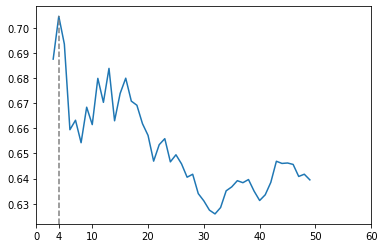

In [33]:
sqr_spike_dst = squareform(spike_dst)
sqr_isi_dst = squareform(isi_dst)

ward_spike = cluster.hierarchy.linkage(spike_dst, method='ward')
ward_isi = cluster.hierarchy.linkage(isi_dst, method='ward')

min_qclust = 3
max_qclust = 50

ncls = np.arange(min_qclust, max_qclust, 1)
metric_scores = np.zeros(ncls.shape[0])
for i, t in enumerate(ncls):
    cls_spike = cluster.hierarchy.fcluster(ward_spike, t=t, criterion='maxclust')
    cls_isi = cluster.hierarchy.fcluster(ward_isi, t=t, criterion='maxclust')
    metric_scores[i] = metrics.adjusted_mutual_info_score(cls_isi, cls_spike)
    
max_cls = np.argmax(metric_scores) + min_qclust
fig, ax = plt.subplots()
ax.plot(ncls, metric_scores)

ax.axvline(max_cls, ymin=0, ymax=(np.max(metric_scores) - ax.get_ylim()[0]) / np.diff(ax.get_ylim()),
           linestyle='--', color='gray')
if max_cls not in list(ax.get_xticks()):
    ax.set_xticks(list(ax.get_xticks()) + [max_cls])
print('Optimum clusters: {}'.format(max_cls))

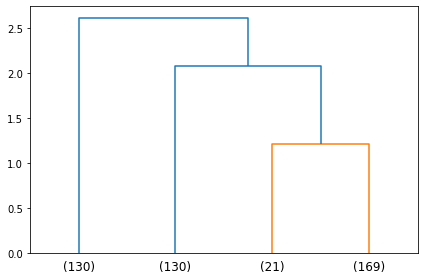

In [34]:
n_cluster = max_cls
cls_spike = cluster.hierarchy.fcluster(ward_spike, t=n_cluster, criterion='maxclust')
fig = plt.figure()
dn = cluster.hierarchy.dendrogram(ward_spike, p=np.unique(cls_spike).shape[0], distance_sort='ascending',
                                  truncate_mode='lastp')
plt.tight_layout()

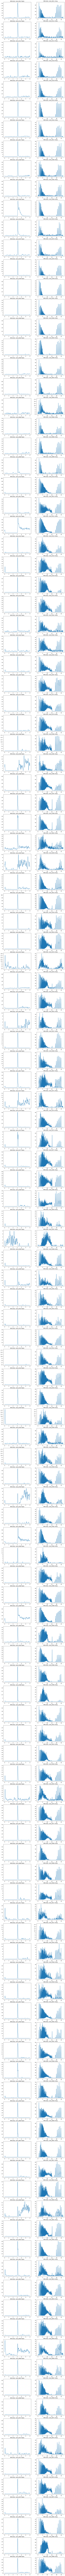

In [36]:
sel = 2
cls_units = np.asarray(exp_unit, dtype='<U9')[cls_spike == sel]
cls_chirp = chirp_psth[cls_spike == sel]
cls_flash = flash_psth[cls_spike == sel]

fig, ax = plt.subplots(cls_units.shape[0], 2, figsize=(12, 4 * cls_units.shape[0]))

for i, (uid, chirp, flash) in enumerate(zip(cls_units, cls_chirp, cls_flash)):
    ax[i][0].plot(flash_time, flash)
    ax[i][1].plot(chirp_time, chirp)
    
    ax[i][0].set_title('{}, {} flash'.format(uid[0], uid[1]))
    ax[i][1].set_title('{}, {} chirp'.format(uid[0], uid[1]))

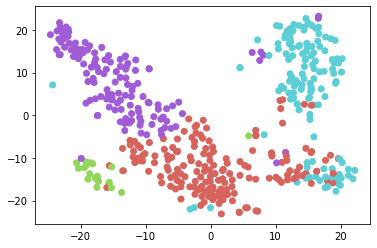

In [39]:
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots()
# ax.plot(np.array(list(chirp_psth.values()))[0])

model = TSNE(n_components=2, random_state=0, perplexity=30)#,init='pca')
proj = model.fit_transform(chirp_psth)

n_flat_clusters = np.unique(cls_spike).shape[0]
show_order = np.unique(cls_spike)[::-1] - 1

ax.scatter(proj[:, 0], proj[:, 1], c=show_order[cls_spike - 1],
           cmap=ListedColormap(sns.hls_palette(n_flat_clusters, l=0.6, s=0.6).as_hex()))